Natural Language Processing - Assignment 1: Classical Baselines + Evaluation Pack

This notebook includes loading, splitting, and preprocessing the data. Then a Logistic Regression is trained, as well as a Linear SVM. They both output a table with evaluation metrics and confusion matrices. Additionally, for error analysis, we find 20 examples of misclassification in each model.

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
import matplotlib.pyplot as plt

Preprocessing the data.

We split the the datainto three: train, validation, and test set. 

We extract the features and target from the data. 

We tokenize and vectorize the data into a matrix of Tf-IDF matrix.

In [2]:
# Loading the dataset and splitting it into train, validation, and test sets
splits = {"train": "train.jsonl", "test": "test.jsonl"}
temp_train_set = pd.read_json("hf://datasets/sh0416/ag_news/" + splits["train"], lines=True)
test_set = pd.read_json("hf://datasets/sh0416/ag_news/" + splits["test"], lines=True)

# Splitting the train set into train and validation set with 9:1 ratio.
train_set, val_set = train_test_split(
    temp_train_set,
    test_size=0.1,
    random_state=42,
    stratify=temp_train_set["label"],
)

/home/zofia_drozdz/NLP/nlp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def separate_labels_text(set: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Separates the labels and text from the given DataFrame.

    Args:
        set (pd.DataFrame): The input DataFrame containing the text and labels.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the features and the labels.
    """
    x = set.drop(columns=["label"])
    y = set["label"]

    return x, y

# Separating the labels and text for train, validation, and test sets
ag_train, y_train = separate_labels_text(train_set)
ag_val, y_val = separate_labels_text(val_set)
ag_test, y_test = separate_labels_text(test_set)

In [4]:
# Vectorizing the text data using TF-IDF
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)

# Transforming the text data into TF-IDF features
X_train = tfidf.fit_transform(ag_train["title"] + " " + ag_train["description"])
X_val = tfidf.transform(ag_val["title"] + " " + ag_val["description"])
X_test = tfidf.transform(ag_test["title"] + " " + ag_test["description"])

Logictic Regression

We train the model using the sklearn logistic regression, but we tune the hyperparameters with a custom grid search function. It iterates over all of the combinations of the hyperparameters and returns the best model, the best combination of hyperparameters, and the best macro f1 score.

We evaluate the model on the validation set using the classification report and a confusion matrix. 

We then evaluate the model on the test set using the classification report and a confusion matrix.

In [5]:
def grid_search_lr(param_grid: dict, x_train, y_train: pd.DataFrame, x_val, y_val: pd.DataFrame, max_iter: int = 100):
    """
    Performs a grid search to find the best hyperparameters for the logistic regression model.

    Args:
        param_grid (dict): A dictionary containing the hyperparameters.
        x_train: The training features.
        y_train (pd.DataFrame): The training labels.
        x_val: The validation features.
        y_val (pd.DataFrame): The validation labels.
        max_iter (int): The maximum number of iterations for the model. Defaults to 100.

    Returns:
        best_model: The model with the best hyperparameters.
        best_macrof1: The best macro F1 score achieved with the best hyperparameters.
        best_params: The best hyperparameters found during the grid search.
    """
    # Initializing variables for the best model, best macro F1 score, and best hyperparameters
    best_model = None
    best_macrof1 = -1.0
    best_params = None

    # Iterating through each combinations of the hyperparameters
    for c in param_grid["C"]:
        for ratio in param_grid["l1_ratio"]:
            # Training the logistic regression model with the current hyperparameters
            model = LogisticRegression(
                C=c,
                solver="saga",
                l1_ratio=ratio,
                max_iter=max_iter,
                random_state=42,
            )
            
            # Fitting the model to the training data
            model.fit(x_train, y_train)

            # Predicting the labels for the validation set
            pred = model.predict(x_val)

            # Evaluating the model using the macro F1 score
            score = f1_score(y_val, pred, average="macro", zero_division=0)

            # Updating the relevant variables if the new model is better
            if score > best_macrof1:
                best_macrof1 = score
                best_model = model
                best_params = {"C": c, "l1_ratio": ratio}

    # Returning the best model, best macro F1 score, and best hyperparameters
    return best_model, best_macrof1, best_params

In [6]:
# Defining the possible hyperparameters for the grid search
param_grid = {
    "C": [0.1, 1],
    "l1_ratio": [0, 1],
}

# Finding the best model, f1 score, and hyperparameters 
best_model, best_macrof1, best_params = grid_search_lr(
    param_grid, X_train, y_train, X_val, y_val
)

# Printing the results of the search
print(best_model)
print(best_macrof1)
print(best_params)

LogisticRegression(C=1, l1_ratio=0, random_state=42, solver='saga')
0.9115420590433607
{'C': 1, 'l1_ratio': 0}


/home/zofia_drozdz/NLP/nlp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

       World       0.92      0.90      0.91      3000
      Sports       0.95      0.98      0.96      3000
    Business       0.88      0.88      0.88      3000
    Sci/Tech       0.89      0.90      0.89      3000

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000



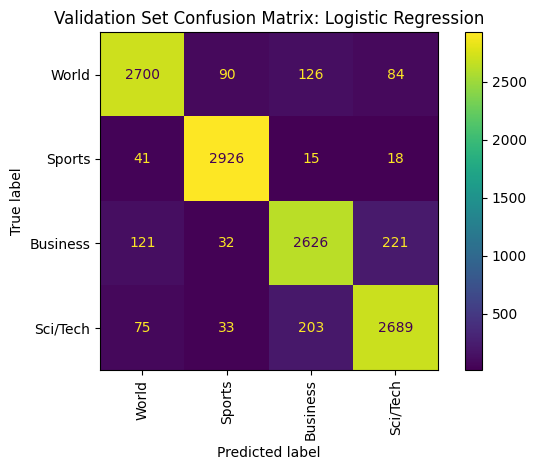

In [7]:
# Defining the label names (classes)
label_names = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

# Predicting the labels for the validation set using the found best model
y_pred_val_lr = best_model.predict(X_val)

# Classification report
print(
    classification_report(
        y_val, y_pred_val_lr, target_names=[label_names[i] for i in sorted(label_names)]
    )
)


# Confusion matrix
conf_matrix_val_lr = confusion_matrix(y_val, y_pred_val_lr)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_val_lr, display_labels=[label_names[i] for i in sorted(label_names)]
)

# Plotting the confusion matrix
disp.plot(xticks_rotation="vertical")
plt.title("Validation Set Confusion Matrix: Logistic Regression")
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

       World       0.92      0.90      0.91      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.87      0.87      0.87      1900
    Sci/Tech       0.88      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



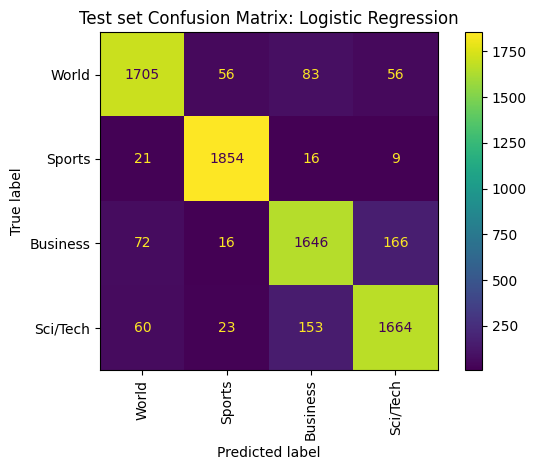

In [8]:
# Predicting the labels for the test set using the found best model
y_pred_test_lr = best_model.predict(X_test)

# Classification report
print(
    classification_report(
        y_test, y_pred_test_lr, target_names=[label_names[i] for i in sorted(label_names)]
    )
)

# Confusion matrix
conf_matrix_test_lr = confusion_matrix(y_test, y_pred_test_lr)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_test_lr, display_labels=[label_names[i] for i in sorted(label_names)]
)

# Plotting the confusion matrix
disp.plot(xticks_rotation="vertical")
plt.title("Test set Confusion Matrix: Logistic Regression")
plt.tight_layout()
plt.show()

In [9]:
def grid_search_svm(param_grid: dict, x_train, y_train: pd.DataFrame, x_val, y_val: pd.DataFrame, max_iter: int=100):
    """
    Performs a grid search to find the best hyperparameters for the linear SVM model.

    Args:
        param_grid (dict): A dictionary containing the hyperparameters.
        x_train: The training features.
        y_train (pd.DataFrame): The training labels.
        x_val: The validation features.
        y_val (pd.DataFrame): The validation labels.
        max_iter (int): The maximum number of iterations for the model. Defaults to 100.

    Returns:
        best_model: The model with the best hyperparameters.
        best_macrof1: The best macro F1 score achieved with the best hyperparameters.
        best_params: The best hyperparameters found during the grid search.
    """
    # Initializing variables for the best model, best macro F1 score, and best hyperparameters
    best_model = None
    best_macrof1 = -1.0
    best_params = None

    # Iterating through each combinations of the hyperparameters
    for c in param_grid["C"]:
        for loss in param_grid["loss"]:
            # Training the logistic regression model with the current hyperparameters
            model = LinearSVC(
                C=c,
                loss=loss,
                max_iter=max_iter,
                random_state=42,
            )

            # Fitting the model to the training data
            model.fit(x_train, y_train)

            # Predicting the labels for the validation set
            pred = model.predict(x_val)

            # Evaluating the model using the macro F1 score
            score = f1_score(y_val, pred, average="macro", zero_division=0)

            # Updating the relevant variables if the new model is better
            if score > best_macrof1:
                best_macrof1 = score
                best_model = model
                best_params = {
                    "C": c,
                    "loss": loss,
                }

    # Returning the best model, best macro F1 score, and best hyperparameters
    return best_model, best_macrof1, best_params

In [10]:
# Defining the possible hyperparameters for the grid search
param_grid_svm = {"C": [0.1, 1], "loss": ["hinge", "squared_hinge"]}

# Finding the best model, f1 score, and hyperparameters
best_model_svm, best_macrof1_svm, best_params_svm = grid_search_svm(
    param_grid_svm, X_train, y_train, X_val, y_val
)

# Printing the results of the search
print(best_model_svm)
print(best_macrof1_svm)
print(best_params_svm)

/home/zofia_drozdz/NLP/nlp/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zofia_drozdz/NLP/nlp/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, loss='hinge', max_iter=100, random_state=42)
0.9141647757068503
{'C': 1, 'loss': 'hinge'}


              precision    recall  f1-score   support

       World       0.93      0.90      0.91      3000
      Sports       0.95      0.98      0.97      3000
    Business       0.89      0.88      0.88      3000
    Sci/Tech       0.89      0.90      0.90      3000

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000



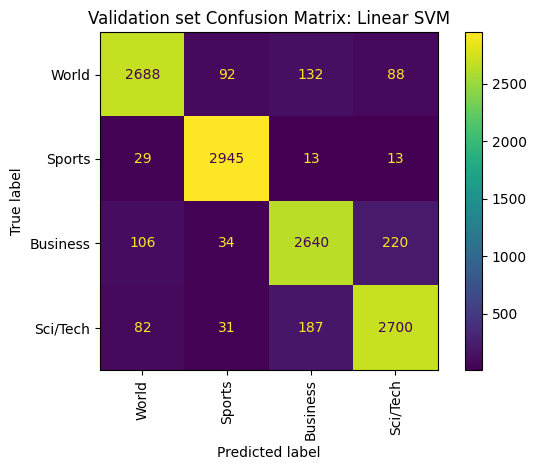

In [11]:
# Predicting the labels for the validation set using the found best model
y_pred_val_svm = best_model_svm.predict(X_val)

# Classification report
print(
    classification_report(
        y_val,
        y_pred_val_svm,
        target_names=[label_names[i] for i in sorted(label_names)],
    )
)

# Confusion matrix
conf_matrix_val_svm = confusion_matrix(y_val, y_pred_val_svm)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_val_svm, display_labels=[label_names[i] for i in sorted(label_names)]
)

# Plotting the confusion matrix
disp.plot(xticks_rotation="vertical")
plt.title("Validation set Confusion Matrix: Linear SVM")
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

       World       0.93      0.90      0.91      1900
      Sports       0.95      0.98      0.97      1900
    Business       0.87      0.87      0.87      1900
    Sci/Tech       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



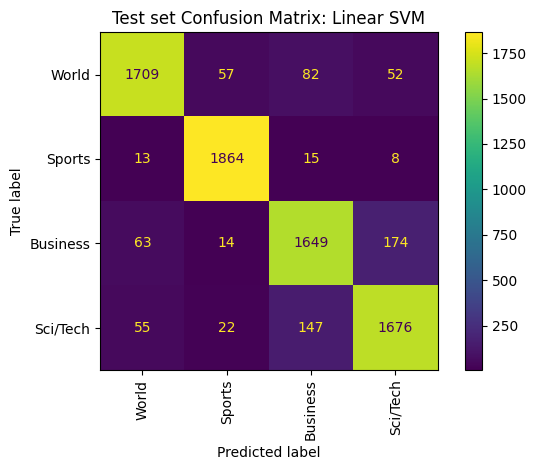

In [12]:
# Predicting the labels for the test set using the found best model
y_pred_test_svm = best_model_svm.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred_test_svm,
        target_names=[label_names[i] for i in sorted(label_names)],
    )
)

# Confusion matrix
conf_matrix_test_svm = confusion_matrix(y_test, y_pred_test_svm)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_test_svm, display_labels=[label_names[i] for i in sorted(label_names)]
)

# Plotting the confusion matrix
disp.plot(xticks_rotation="vertical")
plt.title("Test set Confusion Matrix: Linear SVM")
plt.tight_layout()
plt.show()

Error Analysis

We return 20 misclassifed samples from each model - giving number in the dataset, title of the article, decription of the article, predicted class, and the true class.

In [13]:
pd.set_option("display.max_colwidth", None)

# Error Analysis for Logistic Regression
df_predictions_lr = pd.DataFrame(
    {
        "title": ag_test["title"],
        "description": ag_test["description"],
        "true_label": y_test.map(label_names),
        "pred_label": pd.Series(y_pred_test_lr).map(label_names).values,
    }
)

# Identifying the misclassified Logistic Regression samples
errors_lr = df_predictions_lr[
    df_predictions_lr["true_label"] != df_predictions_lr["pred_label"]
]

# Displaying the first 20 misclassified samples
print("Logistic Regression")
print(f"Total Errors: {len(errors_lr)}")
display(errors_lr.head(20))

# Error Analysis for Linear SVM
df_predictions_svm = pd.DataFrame(
    {
        "title": ag_test["title"],
        "description": ag_test["description"],
        "true_label": y_test.map(label_names),
        "pred_label": pd.Series(y_pred_test_svm).map(label_names).values,
    }
)

# Identifying the misclassified Linear SVM samples
errors_svm = df_predictions_svm[
    df_predictions_svm["true_label"] != df_predictions_svm["pred_label"]
]

# Displaying the first 20 misclassified samples
print("\nLinear SVM")
print(f"Total Errors: {len(errors_svm)}")
display(errors_svm.head(20))

Logistic Regression
Total Errors: 731


,title,description,true_label,pred_label
3,Prediction Unit Helps Forecast Wildfires (AP),"AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.",Sci/Tech,Sports
20,IBM to hire even more new workers,"By the end of the year, the computing giant plans to have its biggest headcount since 1991.",Sci/Tech,Business
23,Some People Not Eligible to Get in on Google IPO,"Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open process with 28 underwriters - all this pointed to a new level of public participation. But this isn't the case.",Sci/Tech,Business
24,Rivals Try to Turn Tables on Charles Schwab,"By MICHAEL LIEDTKE SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an annoying stone in Wall Street's wing-tipped shoes for decades...",Sci/Tech,Business
36,Venezuela Prepares for Chavez Recall Vote,Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market.,World,Business
79,Live: Olympics day four,Richard Faulds and Stephen Parry are going for gold for Great Britain on day four in Athens.,World,Sports
83,Intel to delay product aimed for high-definition TVs,"SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown with Texas Instruments Inc. in the fast-growing market for high-definition television displays.",Business,Sci/Tech
88,U.S. Misses Cut in Olympic 100 Free,"ATHENS, Greece - Top American sprinters Jason Lezak and Ian Crocker missed the cut in the Olympic 100-meter freestyle preliminaries Tuesday, a stunning blow for a country that had always done well in the event. Pieter van den Hoogenband of the Netherlands and Australian Ian Thorpe advanced to the evening semifinal a day after dueling teenager Michael Phelps in the 200 freestyle, won by Thorpe...",World,Sports
106,Stocks Climb on Drop in Consumer Prices,"NEW YORK - Stocks rose for a second straight session Tuesday as a drop in consumer prices allowed investors to put aside worries about inflation, at least for the short term. With gasoline prices falling to eight-month lows, the Consumer Price Index registered a small drop in July, giving consumers a respite from soaring energy prices...",World,Business
110,Yahoo! Ups Ante for Small Businesses,Web giant Yahoo! is gambling that price cuts on its domain name registration and Web hosting products will make it more competitive with discounters in the space -- which means that small businesses looking to move online get a sweeter deal through ...,Business,Sci/Tech



Linear SVM
Total Errors: 702


,title,description,true_label,pred_label
3,Prediction Unit Helps Forecast Wildfires (AP),"AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.",Sci/Tech,Sports
15,Teenage T. rex's monster growth,Tyrannosaurus rex achieved its massive size due to an enormous growth spurt during its adolescent years.,Sci/Tech,Business
20,IBM to hire even more new workers,"By the end of the year, the computing giant plans to have its biggest headcount since 1991.",Sci/Tech,Business
23,Some People Not Eligible to Get in on Google IPO,"Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just five shares, an open process with 28 underwriters - all this pointed to a new level of public participation. But this isn't the case.",Sci/Tech,Business
24,Rivals Try to Turn Tables on Charles Schwab,"By MICHAEL LIEDTKE SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an annoying stone in Wall Street's wing-tipped shoes for decades...",Sci/Tech,Business
36,Venezuela Prepares for Chavez Recall Vote,Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market.,World,Business
79,Live: Olympics day four,Richard Faulds and Stephen Parry are going for gold for Great Britain on day four in Athens.,World,Sports
83,Intel to delay product aimed for high-definition TVs,"SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown with Texas Instruments Inc. in the fast-growing market for high-definition television displays.",Business,Sci/Tech
88,U.S. Misses Cut in Olympic 100 Free,"ATHENS, Greece - Top American sprinters Jason Lezak and Ian Crocker missed the cut in the Olympic 100-meter freestyle preliminaries Tuesday, a stunning blow for a country that had always done well in the event. Pieter van den Hoogenband of the Netherlands and Australian Ian Thorpe advanced to the evening semifinal a day after dueling teenager Michael Phelps in the 200 freestyle, won by Thorpe...",World,Sports
106,Stocks Climb on Drop in Consumer Prices,"NEW YORK - Stocks rose for a second straight session Tuesday as a drop in consumer prices allowed investors to put aside worries about inflation, at least for the short term. With gasoline prices falling to eight-month lows, the Consumer Price Index registered a small drop in July, giving consumers a respite from soaring energy prices...",World,Business
